# Import

## Library dependencies

In [1]:
import os
import pickle

import numpy as np
import pandas as pd

import seaborn as sns
import spacy
from transformers import AutoTokenizer

import constants
import utils

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


## Dataset

In [2]:
dataset_test = utils.load_jsonl_gz(os.path.join(
    constants.OUTPUT_DIR, 
    f'{constants.NUM_REVIEWS}reviews', 
    f'test.jsonl.gz',
))

## General models

In [3]:
# !python -m spacy download en_core_web_sm
# nlp = spacy.load('en_core_web_sm', disable=['tokenizer', 'ner', 'tagger','textcat'])

In [4]:
tokenizer = AutoTokenizer.from_pretrained(
    constants.LONGFORMER_MODEL_TYPE,
    max_length=constants.MAX_SEQ_LENGTH,
)

## Cached files

In [5]:
### Load the texts and predictions
summ_generated = {}
summ_predicted = {}

# load baseline
summ_generated['baseline'] = utils.load_jsonl_gz(os.path.join(
    constants.OUTPUT_DIR, 
    f'{constants.NUM_REVIEWS}reviews', 
    f'test.jsonl.gz',
))
with open(os.path.join(
    constants.SCORING_DIR, 
    f'preds_baseline.pkl',
), "rb") as f:
    summ_predicted['baseline'] = pickle.load(f)

# load random summaries
for i in range(10):
    summ_generated[f'random_{i}'] = utils.load_jsonl_gz(os.path.join(
        constants.SUMMARY_DIR, 
        f'{constants.NUM_REVIEWS}reviews', 
        f't{constants.SUMMARY_TOKEN_LIMIT}_random_{i}.jsonl.gz',
    ))
    with open(os.path.join(
        constants.SCORING_DIR, 
        f'preds_t{constants.SUMMARY_TOKEN_LIMIT}_random_{i}.pkl',
    ), "rb") as f:
        summ_predicted[f'random_{i}'] = pickle.load(f)

# Load decsum summaries
for decsum_type in ['001', '010', '011']:
    summ_generated[f'decsum{decsum_type}'] = utils.load_jsonl_gz(os.path.join(
        constants.SUMMARY_DIR, 
        f'{constants.NUM_REVIEWS}reviews', 
        f't{constants.SUMMARY_TOKEN_LIMIT}_decsum{decsum_type}_beam{constants.DECSUM_BEAM_WIDTH}.jsonl.gz',
    ))
    with open(os.path.join(
        constants.SCORING_DIR, 
        f'preds_t{constants.SUMMARY_TOKEN_LIMIT}_decsum{decsum_type}_beam{constants.DECSUM_BEAM_WIDTH}.pkl',
    ), "rb") as f:
        summ_predicted[f'decsum{decsum_type}'] = pickle.load(f)

# Load sampled summaries
for i in range(10):
    summ_generated[f'malsampledmin_{i}'] = utils.load_jsonl_gz(os.path.join(
        constants.SUMMARY_DIR, 
        f'{constants.NUM_REVIEWS}reviews', 
        f't{constants.SUMMARY_TOKEN_LIMIT}_malsampledmin_{i}.jsonl.gz',
    ))
    with open(os.path.join(
        constants.SCORING_DIR, 
        f'preds_t{constants.SUMMARY_TOKEN_LIMIT}_malsampledmin_{i}.pkl',
    ), "rb") as f:
        summ_predicted[f'malsampledmin_{i}'] = pickle.load(f)
    summ_generated[f'malsampledmax_{i}'] = utils.load_jsonl_gz(os.path.join(
        constants.SUMMARY_DIR, 
        f'{constants.NUM_REVIEWS}reviews', 
        f't{constants.SUMMARY_TOKEN_LIMIT}_malsampledmax_{i}.jsonl.gz',
    ))
    with open(os.path.join(
        constants.SCORING_DIR, 
        f'preds_t{constants.SUMMARY_TOKEN_LIMIT}_malsampledmax_{i}.pkl',
    ), "rb") as f:
        summ_predicted[f'malsampledmax_{i}'] = pickle.load(f)

# Load ranked summaries
summ_generated['malrankedmin'] = utils.load_jsonl_gz(os.path.join(
    constants.SUMMARY_DIR, 
    f'{constants.NUM_REVIEWS}reviews', 
    f't{constants.SUMMARY_TOKEN_LIMIT}_malrankedmin.jsonl.gz',
))
with open(os.path.join(
    constants.SCORING_DIR, 
    f'preds_t{constants.SUMMARY_TOKEN_LIMIT}_malrankedmin.pkl',
), "rb") as f:
    summ_predicted['malrankedmin'] = pickle.load(f)
summ_generated['malrankedmax'] = utils.load_jsonl_gz(os.path.join(
    constants.SUMMARY_DIR, 
    f'{constants.NUM_REVIEWS}reviews', 
    f't{constants.SUMMARY_TOKEN_LIMIT}_malrankedmax.jsonl.gz',
))
with open(os.path.join(
    constants.SCORING_DIR, 
    f'preds_t{constants.SUMMARY_TOKEN_LIMIT}_malrankedmax.pkl',
), "rb") as f:
    summ_predicted['malrankedmax'] = pickle.load(f)

# Load baseline-matching summaries
summ_generated['meetbaseline'] = utils.load_jsonl_gz(os.path.join(
    constants.SUMMARY_DIR, 
    f'{constants.NUM_REVIEWS}reviews', 
    f't{constants.SUMMARY_TOKEN_LIMIT}_meetbaseline.jsonl.gz',
))
with open(os.path.join(
    constants.SCORING_DIR, 
    f'preds_t{constants.SUMMARY_TOKEN_LIMIT}_meetbaseline.pkl',
), "rb") as f:
    summ_predicted['meetbaseline'] = pickle.load(f)

In [6]:
### Load prediction cache files

# Prediction model cache file
with open(os.path.join(
    constants.BACKUPS_DIR,
    f'{constants.NUM_REVIEWS}reviews',
    'decsumhelperr_test.pkl',
), "rb") as f:
    helper_sentpredictions = pickle.load(f)

# Sentbert encodings cache file
with open(os.path.join(
    constants.BACKUPS_DIR,
    f'{constants.NUM_REVIEWS}reviews',
    'decsumhelperd_test.pkl',
), "rb") as f:
    helper_sentembeddings = pickle.load(f)

# Lists of split sentence annotations
# In format [(position, sentence, tokencount, input_ids, attention_mask), ...]
with open(os.path.join(
    constants.BACKUPS_DIR,
    f'{constants.NUM_REVIEWS}reviews',
    'sentencesplit_test.pkl',
), "rb") as f:
    helper_sentannotations = pickle.load(f)

In [7]:
### Create a per-business sentence index -> prediction mapping
helper_mod_sentpredmapping = [
    dict(zip([e[0] for e in helper_sentannotations[i]], helper_sentpredictions[i]))
    for i in range(len(helper_sentannotations))
]

In [8]:
### Create a per-business sentence index -> review index mapping
helper_mod_sentreviewmapping = []
for b_i in range(len(dataset_test)):
    r_lastusedix = 0
    r_lastusedtext = dataset_test[b_i]['reviews'][r_lastusedix]
    b_mapping = {
        'sent_to_review': {},
        'review_to_sent': {0: []},
    }
    for s_i in range(len(helper_sentannotations[b_i])):
        currenttext = helper_sentannotations[b_i][s_i][1]
        foundix = r_lastusedtext.find(currenttext[:min(len(currenttext), 15)])
        if foundix<0:
            # update the tracking info
            r_lastusedix += 1
            b_mapping['review_to_sent'][r_lastusedix] = []
            if r_lastusedix<len(dataset_test[b_i]['reviews']):
                r_lastusedtext = dataset_test[b_i]['reviews'][r_lastusedix]
        # save the info
        b_mapping['sent_to_review'][s_i] = r_lastusedix
        b_mapping['review_to_sent'][r_lastusedix].append(s_i)
        # update what text is available to search through
        update_size = 0
        if foundix>0:
            update_size = foundix+len(currenttext)
        r_lastusedtext = r_lastusedtext[update_size:]
    helper_mod_sentreviewmapping.append(b_mapping)

# Modify

## Wasserstein distance

In [9]:
# Calculate the log(Wasserstein distance) representativeness metric (lower is better) for a given summary against the baseline
# sentence_cache : Mapping of all sentence indices (as recognized by SpaCy) to their prediction values.
# summary_text_indices : Summary in list of sentence indices form
#                        Assumes that all sentences are EXTRACTIVE
def wdistance(sentence_cache, summary_text_indices, baseline_indices):
    # check input fail conditions
    if len(summary_text_indices)==0:
        return None
    if len(baseline_indices)==0:
        return None
    # identify predictions per sentence
    summary_sentence_preds = [sentence_cache[e] for e in summary_text_indices]
    # identify predictions per baseline
    baseline_sentence_preds = [sentence_cache[e] for e in baseline_indices]
    # calculate Wasserstein distance
    return utils.compute_wasserstein(summary_sentence_preds, baseline_sentence_preds)

# Demo this function - calculate W-distance of the first summary in random_0
wdistance(
    helper_mod_sentpredmapping[0],
    summ_generated['random_0'][0]['sentence_ix'],
    helper_mod_sentpredmapping[0].keys(),
)

-0.689862496841768

### Per summary, against the entire review body

In [10]:
### Create a summary type -> summary index -> log-W-distance mapping
helper_mod_summbasewasserstein = {}
for k in summ_generated.keys():
    helper_mod_summbasewasserstein[k] = []
    for i in range(len(summ_generated[k])):
        if k!='baseline':
            temp_selectedixs = summ_generated[k][i]['sentence_ix']
        else:
            temp_selectedixs = [e[0] for e in helper_sentannotations[i]]
        helper_mod_summbasewasserstein[k].append(wdistance(
            helper_mod_sentpredmapping[i],
            temp_selectedixs,
            helper_mod_sentpredmapping[i].keys(),
        ))

/home/jz549/projects/summary_nlp/utils.py:72: RuntimeWarning: divide by zero encountered in log
  return np.log(wasserstein_distance(pred1, pred2))


### Per summary, against only the reviews that were cited

In [11]:
### Create a summary type -> summary index -> log-W-distance mapping
helper_mod_summrevbwasserstein = {}
for k in summ_generated.keys():
    helper_mod_summrevbwasserstein[k] = []
    for i in range(len(summ_generated[k])):
        if k!='baseline':
            temp_selectedixs = summ_generated[k][i]['sentence_ix']
        else:
            temp_selectedixs = [e[0] for e in helper_sentannotations[i]]
        reviews_cited = list(set([
            helper_mod_sentreviewmapping[i]['sent_to_review'][s_i] 
            for s_i in temp_selectedixs
        ]))
        reviews_cited_sentences = [
            helper_mod_sentreviewmapping[i]['review_to_sent'][r_i]
            for r_i in reviews_cited
        ]
        helper_mod_summrevbwasserstein[k].append(wdistance(
            helper_mod_sentpredmapping[i],
            temp_selectedixs,
            [e for sl in reviews_cited_sentences for e in sl],
        ))

## Baseline score of only cited reviews

In [12]:
### Create a summary type -> summary index -> review avg score
helper_mod_summrevbavgscore = {}
for k in summ_generated.keys():
    helper_mod_summrevbavgscore[k] = []
    for i in range(len(summ_generated[k])):
        if k=='baseline':
            temp_revscores = summ_generated[k][i]['scores']
        else:
            temp_selectedixs = summ_generated[k][i]['sentence_ix']
            reviews_cited = list(set([
                helper_mod_sentreviewmapping[i]['sent_to_review'][s_i] 
                for s_i in temp_selectedixs
            ]))
            temp_revscores = [summ_generated[k][i]['scores'][r_i] for r_i in reviews_cited]
        if len(temp_revscores)>0:
            temp_revscores = sum(temp_revscores)/len(temp_revscores)
        else:
            temp_revscores = summ_generated[k][i]['avg_score']
        helper_mod_summrevbavgscore[k].append(temp_revscores)

## Compile all summaries into a single collection

In [13]:
temp_allsummaries = []
for k in summ_generated.keys():
    # get the general summary type (does not include seeds)
    summ_type = k
    if '_' in summ_type:
        summ_type = summ_type[:-2]
    for b_i in range(len(summ_generated[k])):
        b_uid = summ_generated[k][b_i]['business']
        b_scores = summ_generated[k][b_i]['scores']
        b_avg_score = summ_generated[k][b_i]['avg_score']
        gen_reviews = summ_generated[k][b_i]['reviews']
        if k!='baseline':
            gen_sentence_ix = summ_generated[k][b_i]['sentence_ix']
        else:
            gen_sentence_ix = [i for i in range(len(summ_generated[k][b_i]['reviews']))]
        gen_cited_score = helper_mod_summrevbavgscore[k][b_i]
        pred_score = summ_predicted[k][0][b_i][0]
        pred_logwdist_10rev = helper_mod_summbasewasserstein[k][b_i]
        pred_logwdist_cited = helper_mod_summrevbwasserstein[k][b_i]
        temp_allsummaries.append({
            'summ_fname': k,
            'summ_type': summ_type,
            'b_i': b_i,
            'b_uid': b_uid,
            'b_scores': b_scores,
            'b_avg_score': b_avg_score,
            'gen_reviews': gen_reviews,
            'gen_sentence_ix': gen_sentence_ix,
            'gen_cited_score': gen_cited_score,
            'pred_score': pred_score,
            'pred_logwdist_10rev': pred_logwdist_10rev,
            'pred_logwdist_cited': pred_logwdist_cited,
        })
df_allsummaries = pd.DataFrame(temp_allsummaries)

# Analysis: Manipulability?

- Is it possible to generate extractive summaries that are intentionally designed to defend a particular prediction (in contrast to one made in good faith for an existing model)?
- Is it easier/harder for certain cases?

## MSE, Mean Wasserstein, Mean Error, Fraction Higher, Referenced-Only Mean Wasserstein (All summary types in original groups)

In [14]:
temp_mse_pergroup = []
for k in summ_generated.keys():
    score_msefull = utils.compute_mse(
        summ_predicted[k][0],
        summ_predicted['baseline'][0], 
    )
    score_mse = summ_predicted[k][2]['test_mse']
    wscores = [e for e in helper_mod_summbasewasserstein[k] if (e is not None) and e>-100]
    if k=='baseline':
        review_avgscores = [
            (b_i, summ_generated[k][b_i]['scores'])
            for b_i in range(len(summ_generated[k]))
        ]
    else:
        review_avgscores = [
            (b_i, summ_generated[k][b_i]['sentence_ix'], helper_mod_sentreviewmapping[b_i]['sent_to_review'])
            for b_i in range(len(helper_mod_sentreviewmapping))
        ]
        review_avgscores = [
            (b_i, list(set([mapping[si] for si in sis])))
            for (b_i, sis, mapping) in review_avgscores
        ]
        review_avgscores = [
            (b_i,[summ_generated['baseline'][b_i]['scores'][i] for i in reviews])
            for (b_i, reviews) in review_avgscores
        ]
    review_avgscores = [
        (sum(revratings)/len(revratings)) if len(revratings)>0 else summ_generated[k][b_i]['avg_score']
        for (b_i, revratings) in review_avgscores
    ]
    score_msecited = utils.compute_mse(
        summ_predicted[k][0],
        review_avgscores, 
    )
    wscores = [e for e in helper_mod_summbasewasserstein[k] if (e is not None) and e>-100]
    score_mws = (sum(wscores)/len(wscores)) if len(wscores)>0 else helper_mod_summbasewasserstein[k][0]
    wscitedcores = [e for e in helper_mod_summrevbwasserstein[k] if (e is not None) and e>-100]
    score_mwscited = (sum(wscitedcores)/len(wscitedcores)) if len(wscitedcores)>0 else helper_mod_summrevbwasserstein[k][0]
    score_merfull = utils.compute_merror(
        summ_predicted[k][0],
        summ_predicted['baseline'][0], 
    )
    score_mer = utils.compute_merror(
        summ_predicted[k][0],
        [dataset_test[i]['avg_score'] for i in range(len(summ_predicted[k][0]))], 
    )
    score_fhifull = utils.compute_frachigher(
        summ_predicted[k][0],
        summ_predicted['baseline'][0], 
    )
    score_fhi = utils.compute_frachigher(
        summ_predicted[k][0],
        [dataset_test[i]['avg_score'] for i in range(len(summ_predicted[k][0]))], 
    )
    temp_mse_pergroup.append({
        'summ_type': k,
        'msefull': score_msefull,
        'mse': score_mse,
        'msecited': score_msecited,
        'mws': score_mws,
        'mwscited': score_mwscited,
        'c_1msefull_1mws': score_msefull+score_mws,
        'merfull': score_merfull,
        'mer': score_mer,
        'fhifull': score_fhifull,
        'fhi': score_fhi,
    })
df_mse_pergroup = pd.DataFrame(temp_mse_pergroup)
df_mse_pergroup

,summ_type,msefull,mse,msecited,mws,mwscited,c_1msefull_1mws,merfull,mer,fhifull,fhi
0,baseline,0.000000,0.129930,0.120718,-inf,-inf,-inf,0.000000,0.136737,0.000000,0.654123
1,random_0,0.402504,0.472541,0.629293,-0.864243,-1.018415,-0.461739,-0.117518,0.019219,0.448945,0.535235
2,random_1,0.407544,0.486509,0.657778,-0.864940,-1.016387,-0.457396,-0.121702,0.015036,0.457095,0.536913
3,random_2,0.407563,0.482662,0.640007,-0.867200,-1.015425,-0.459637,-0.132074,0.004664,0.443193,0.521333
4,random_3,0.383639,0.461111,0.613325,-0.868856,-1.021629,-0.485217,-0.110429,0.026309,0.450384,0.530681
5,random_4,0.402271,0.476877,0.627087,-0.862559,-1.005371,-0.460288,-0.118074,0.018663,0.458773,0.533078
6,random_5,0.400297,0.462935,0.615082,-0.864875,-1.021390,-0.464578,-0.124274,0.012464,0.445829,0.533797
7,random_6,0.401194,0.460348,0.635111,-0.864269,-1.008631,-0.463074,-0.134466,0.002272,0.449185,0.529722
8,random_7,0.399913,0.477820,0.640190,-0.863267,-1.019055,-0.463354,-0.120142,0.016596,0.448945,0.530201
9,random_8,0.393486,0.473374,0.664913,-0.869226,-1.008840,-0.475740,-0.120613,0.016124,0.454938,0.540268


In [15]:
### Take the average of all of these across the different random seeds
# average of malsampledmin
temp_malsampledmin_mean = df_mse_pergroup[df_mse_pergroup.apply(
    lambda r: 'malsampledmin_' in r['summ_type'], axis=1
)][['msefull', 'mse', 'msecited', 'mws', 'mwscited', 'c_1msefull_1mws', 'merfull', 'mer', 'fhifull', 'fhi']].mean()
temp_malsampledmin_mean['summ_type'] = 'malsampledmin_mean'
# average of malsampledmax
temp_malsampledmax_mean = df_mse_pergroup[df_mse_pergroup.apply(
    lambda r: 'malsampledmax_' in r['summ_type'], axis=1
)][['msefull', 'mse', 'msecited', 'mws', 'mwscited', 'c_1msefull_1mws', 'merfull', 'mer', 'fhifull', 'fhi']].mean()
temp_malsampledmax_mean['summ_type'] = 'malsampledmax_mean'
# average of random
temp_random_mean = df_mse_pergroup[df_mse_pergroup.apply(
    lambda r: 'random_' in r['summ_type'], axis=1
)][['msefull', 'mse', 'msecited', 'mws', 'mwscited', 'c_1msefull_1mws', 'merfull', 'mer', 'fhifull', 'fhi']].mean()
temp_random_mean['summ_type'] = 'random_mean'
df_mse_pergroup_mean = pd.concat([
    df_mse_pergroup[df_mse_pergroup['summ_type']=='baseline'],
    pd.DataFrame([temp_random_mean]),
    df_mse_pergroup[df_mse_pergroup['summ_type']=='decsum001'],
    df_mse_pergroup[df_mse_pergroup['summ_type']=='decsum010'],
    df_mse_pergroup[df_mse_pergroup['summ_type']=='decsum011'],
    pd.DataFrame([temp_malsampledmin_mean]),
    pd.DataFrame([temp_malsampledmax_mean]),
    df_mse_pergroup[df_mse_pergroup['summ_type']=='malrankedmin'],
    df_mse_pergroup[df_mse_pergroup['summ_type']=='malrankedmax'],
    df_mse_pergroup[df_mse_pergroup['summ_type']=='meetbaseline'],
])
df_mse_pergroup_mean

,summ_type,msefull,mse,msecited,mws,mwscited,c_1msefull_1mws,merfull,mer,fhifull,fhi
0,baseline,0.000000,0.129930,0.120718,-inf,-inf,-inf,0.000000,0.136737,0.000000,0.654123
0,random_mean,0.398852,0.472205,0.638469,-0.865105,-1.014420,-0.466253,-0.120430,0.016308,0.452493,0.533869
11,decsum001,0.515600,0.571552,0.766213,-0.844833,-1.030909,-0.329234,-0.193512,-0.056775,0.412033,0.501678
12,decsum010,0.177792,0.253717,0.584708,-1.248487,-1.293990,-1.070696,-0.128657,0.008080,0.358581,0.506232
13,decsum011,0.183826,0.272300,0.519397,-1.353049,-1.364445,-1.169224,-0.078758,0.057979,0.434803,0.552253
0,malsampledmin_mean,0.736699,0.691319,0.817354,-0.672877,-0.872484,0.063823,-0.560260,-0.423523,0.188758,0.278667
0,malsampledmax_mean,0.348744,0.459216,0.621198,-0.868693,-1.023034,-0.519949,0.018469,0.155207,0.542522,0.617713
34,malrankedmin,3.700077,3.290546,2.185802,0.428660,0.118836,4.128737,-1.862001,-1.725264,0.000959,0.003356
35,malrankedmax,1.139938,1.483637,0.642594,-0.028349,-0.353393,1.111590,0.922184,1.058924,0.995206,0.992090
36,meetbaseline,0.063499,0.204466,0.498654,-0.564483,-0.743977,-0.500984,-0.003832,0.132905,0.586290,0.665868


## Range of potential summary results vs true 50-rating?

In [16]:
temp_plotting_df = []
for group_name, group_df in df_allsummaries.groupby(['b_i']):
    group_avg_score = group_df['b_avg_score'].iloc[0]
    group_variance = np.var(group_df['b_scores'].iloc[0])
    summpred_min = min(group_df['pred_score'])
    summpred_max = max(group_df['pred_score'])
    temp_plotting_df.append({
        'b_i': group_name,
        'b_avg_score': group_avg_score,
        'b_variance': group_variance,
        'summpred': summpred_min,
        'summpred_diff': summpred_min-group_avg_score,
        'summpred_diff_frac': (group_avg_score-summpred_min)/(group_avg_score-1),
        'summpred_diff_gap': summpred_max-summpred_min,
        'summpred_type': 'min',
    })
    temp_plotting_df.append({
        'b_i': group_name,
        'b_avg_score': group_avg_score,
        'b_variance': group_variance,
        'summpred': summpred_max,
        'summpred_diff': summpred_max-group_avg_score,
        'summpred_diff_frac': (summpred_max-group_avg_score)/(5-group_avg_score),
        'summpred_diff_gap': summpred_max-summpred_min,
        'summpred_type': 'max',
    })
temp_plotting_df = pd.DataFrame(temp_plotting_df)

temp_min = temp_plotting_df[temp_plotting_df['summpred_type']=='min'].groupby(pd.cut(temp_plotting_df['b_avg_score'], 36, include_lowest=True)).mean()
temp_min['summpred_type'] = 'min'
temp_max = temp_plotting_df[temp_plotting_df['summpred_type']=='max'].groupby(pd.cut(temp_plotting_df['b_avg_score'], 36, include_lowest=True)).mean()
temp_max['summpred_type'] = 'max'
temp_plotting_grouped_df = pd.concat([
    temp_min,
    temp_max,
])

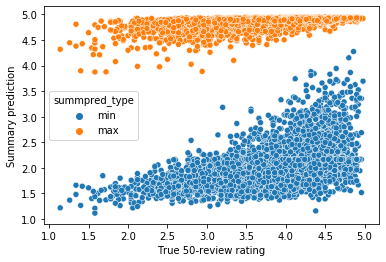

In [17]:
_ = sns.scatterplot(
    data=temp_plotting_df, x="b_avg_score", y="summpred", hue="summpred_type"
).set(
    xlabel='True 50-review rating', ylabel='Summary prediction'
)

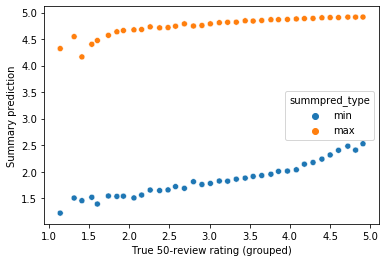

In [18]:
_ = sns.scatterplot(
    data=temp_plotting_grouped_df, x="b_avg_score", y="summpred", hue="summpred_type"
).set(
    xlabel='True 50-review rating (grouped)', ylabel='Summary prediction'
)

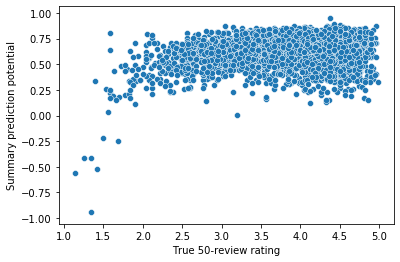

In [19]:
_ = sns.scatterplot(
    data=temp_plotting_df[temp_plotting_df['summpred_type']=='min'], x="b_avg_score", y="summpred_diff_frac"
).set(
    xlabel='True 50-review rating', ylabel='Summary prediction potential'
)

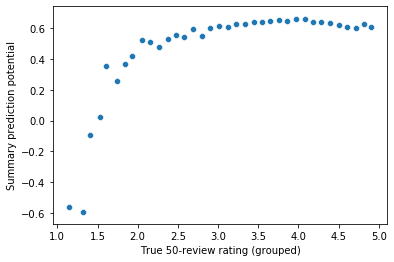

In [20]:
_ = sns.scatterplot(
    data=temp_plotting_grouped_df[temp_plotting_grouped_df['summpred_type']=='min'], x="b_avg_score", y="summpred_diff_frac"
).set(
    xlabel='True 50-review rating (grouped)', ylabel='Summary prediction potential'
)

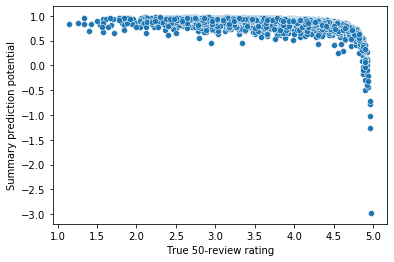

In [21]:
_ = sns.scatterplot(
    data=temp_plotting_df[temp_plotting_df['summpred_type']=='max'], x="b_avg_score", y="summpred_diff_frac"
).set(
    xlabel='True 50-review rating', ylabel='Summary prediction potential'
)

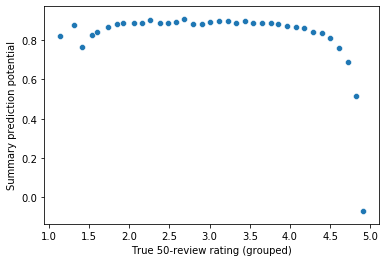

In [22]:
_ = sns.scatterplot(
    data=temp_plotting_grouped_df[temp_plotting_grouped_df['summpred_type']=='max'], x="b_avg_score", y="summpred_diff_frac"
).set(
    xlabel='True 50-review rating (grouped)', ylabel='Summary prediction potential'
)

## Range of potential summary predictions vs 10-review variance?

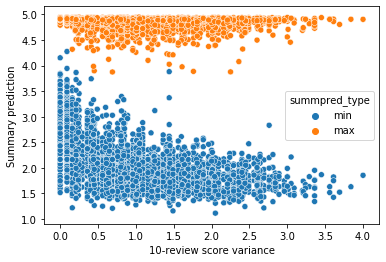

In [23]:
_ = sns.scatterplot(
    data=temp_plotting_df, x="b_variance", y="summpred", hue="summpred_type"
).set(
    xlabel='10-review score variance', ylabel='Summary prediction'
)

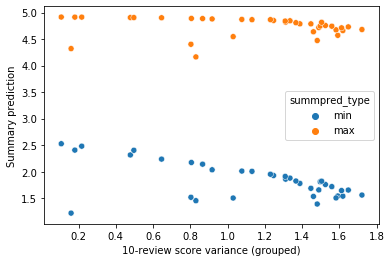

In [24]:
_ = sns.scatterplot(
    data=temp_plotting_grouped_df, x="b_variance", y="summpred", hue="summpred_type"
).set(
    xlabel='10-review score variance (grouped)', ylabel='Summary prediction'
)

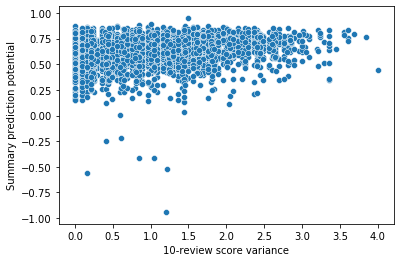

In [25]:
_ = sns.scatterplot(
    data=temp_plotting_df[temp_plotting_df['summpred_type']=='min'], x="b_variance", y="summpred_diff_frac"
).set(
    xlabel='10-review score variance', ylabel='Summary prediction potential'
)

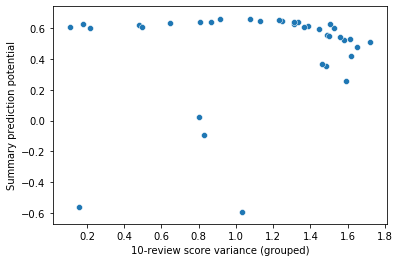

In [26]:
_ = sns.scatterplot(
    data=temp_plotting_grouped_df[temp_plotting_grouped_df['summpred_type']=='min'], x="b_variance", y="summpred_diff_frac"
).set(
    xlabel='10-review score variance (grouped)', ylabel='Summary prediction potential'
)

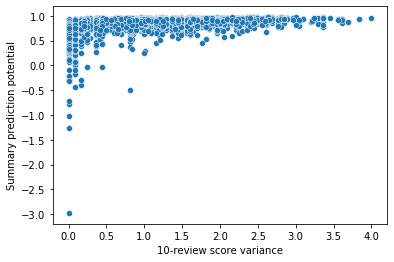

In [27]:
_ = sns.scatterplot(
    data=temp_plotting_df[temp_plotting_df['summpred_type']=='max'], x="b_variance", y="summpred_diff_frac"
).set(
    xlabel='10-review score variance', ylabel='Summary prediction potential'
)

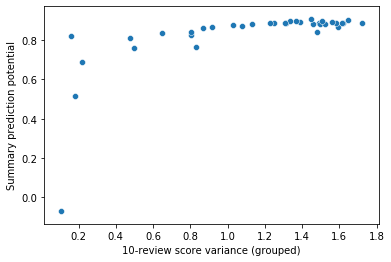

In [28]:
_ = sns.scatterplot(
    data=temp_plotting_grouped_df[temp_plotting_grouped_df['summpred_type']=='max'], x="b_variance", y="summpred_diff_frac"
).set(
    xlabel='10-review score variance (grouped)', ylabel='Summary prediction potential'
)

## True 50-rating vs 10-review variance?

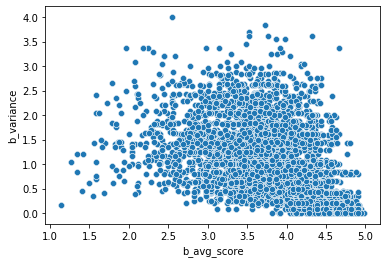

In [29]:
_ = sns.scatterplot(data=temp_plotting_df, x="b_avg_score", y="b_variance")

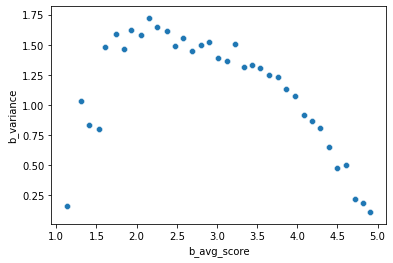

In [30]:
_ = sns.scatterplot(data=temp_plotting_grouped_df, x="b_avg_score", y="b_variance")

# (Code exploration)

In [31]:
# temp_plotting_df[:2]

In [32]:
# temp_plotting_grouped_df[:2]

In [33]:
# temp_plotting_df.groupby(pd.cut(temp_plotting_df['b_avg_score', 'b_variance'], 36, include_lowest=True)).mean()[:5]

In [34]:
# _ = sns.heatmap(temp_plotting_df[['b_avg_score', 'b_variance']])

In [35]:
# df_allsummaries[df_allsummaries['summ_type']!='baseline'][:5]

In [36]:
for k in summ_generated.keys():
    if k!='baseline':
        print(k)
        print(summ_generated[k][512])
        print()

random_0
{'reviews': [' Delicious.', "You shouldn't have a four top, in the center of the busiest room in the place, left unavailable on a Saturday night, especially when everyone can see it and see themselves sitting around it."], 'scores': [3.0, 3.0, 4.0, 4.0, 4.0, 3.0, 4.0, 5.0, 4.0, 4.0], 'business': '5QsipB9-N4RMj94c-CvwUw', 'avg_score': 3.38, 'sentence_ix': [108, 70]}

random_1
{'reviews': ['We had great food and good, but rushed service.', "\n\nOur server was great, and the manager did stop over to talk with us about the experience, explaining much of the technique behind the food we'd been served to that point."], 'scores': [3.0, 3.0, 4.0, 4.0, 4.0, 3.0, 4.0, 5.0, 4.0, 4.0], 'business': '5QsipB9-N4RMj94c-CvwUw', 'avg_score': 3.38, 'sentence_ix': [11, 88]}

random_2
{'reviews': [' An omelete for dinner???'], 'scores': [3.0, 3.0, 4.0, 4.0, 4.0, 3.0, 4.0, 5.0, 4.0, 4.0], 'business': '5QsipB9-N4RMj94c-CvwUw', 'avg_score': 3.38, 'sentence_ix': [164]}

random_3
{'reviews': [' At one 